# 下载数据

In [8]:
!mkdir data
!wget -P "data" https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/test.zip
!wget -P "data"  https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/train_preliminary.zip

--2020-05-24 04:08:15--  https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/test.zip
Resolving tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com (tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com)... 169.254.0.47
Connecting to tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com (tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com)|169.254.0.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226566169 (216M) [application/zip]
Saving to: ‘data/test.zip’

test.zip            100%[===================>] 216.07M  21.7MB/s    in 10s     

2020-05-24 04:08:25 (20.8 MB/s) - ‘data/test.zip’ saved [226566169/226566169]

--2020-05-24 04:08:25--  https://tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com/cephfs/tesla_common/deeplearning/dataset/algo_contest/train_preliminary.zip
Resolving tesla-ap-shanghai-1256322946.cos.ap-shanghai.myqcloud.com (tesla-ap-shanghai-125632

In [2]:
!unzip data/train_preliminary.zip -d data
!unzip data/test.zip -d data

Archive:  data/train_preliminary.zip
   creating: data/train_preliminary/
  inflating: data/train_preliminary/ad.csv  
  inflating: data/train_preliminary/click_log.csv  
  inflating: data/train_preliminary/user.csv  
  inflating: data/train_preliminary/README  
Archive:  data/test.zip
   creating: data/test/
  inflating: data/test/ad.csv        
  inflating: data/test/click_log.csv  
  inflating: data/test/README        


# 处理数据

In [2]:
!pip install gensim lightgbm

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     |████████████████████████████████| 24.2 MB 4.5 MB/s eta 0:00:01     |█████████████████▍              | 13.2 MB 989 kB/s eta 0:00:12
     |████████████████████████████████| 1.2 MB 47.4 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 100.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 98.3 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 72.3 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 105.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 78.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 547 kB 27.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-2.0.0-py3-none-any.whl size=101341 sha256=44edacea7edb9e5412be464cb2dab73f16b8e67983549371621d5dbcac4f3b1a
  Stored in directory:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
from gensim.models import Word2Vec
import logging
import random
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def read_pkl(file):
    with open(file, 'rb') as f:
        return pk.load(f)


def to_pkl(var, file):
    with open(file, mode='wb') as f:
        pk.dump(var, f)

def setup_seed(seed):
     np.random.seed(seed)
     random.seed(seed)
    #  torch.manual_seed(seed)
    #  torch.cuda.manual_seed_all(seed)
    #  torch.backends.cudnn.deterministic = True


data_path = "data/"
setup_seed(1994)

In [13]:
# 训练集

train_log = pd.read_csv("data/train_preliminary/click_log.csv")
train_user = pd.read_csv("data/train_preliminary/user.csv")
train_ad = pd.read_csv('data/train_preliminary/ad.csv')

train_mer = pd.merge(train_log, train_user, on='user_id')
train_mer = pd.merge(train_mer, train_ad, on="creative_id")

train_mer.loc[train_mer['product_id']==r'\N', "product_id"] = 0
train_mer.loc[train_mer['industry']==r'\N', "industry"] = 0

train_mer['product_id'] = train_mer['product_id'].astype(np.int64)
train_mer['industry'] = train_mer['industry'].astype(np.int64)

train_mer.to_csv(data_path+"train_mer.csv", index=False)
train_mer.info()
train_mer.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30082771 entries, 0 to 30082770
Data columns (total 11 columns):
 #   Column            Dtype
---  ------            -----
 0   time              int64
 1   user_id           int64
 2   creative_id       int64
 3   click_times       int64
 4   age               int64
 5   gender            int64
 6   ad_id             int64
 7   product_id        int64
 8   product_category  int64
 9   advertiser_id     int64
 10  industry          int64
dtypes: int64(11)
memory usage: 2.7 GB


,time,user_id,creative_id,click_times,age,gender,ad_id,product_id,product_category,advertiser_id,industry
0,9,30920,567330,1,2,1,504423,30673,3,32638,319
1,15,320815,567330,1,3,1,504423,30673,3,32638,319
2,11,355089,567330,1,1,1,504423,30673,3,32638,319
3,9,363442,567330,1,2,1,504423,30673,3,32638,319
4,14,370513,567330,1,4,1,504423,30673,3,32638,319
5,9,372445,567330,1,2,1,504423,30673,3,32638,319
6,16,399556,567330,2,4,1,504423,30673,3,32638,319
7,10,429834,567330,1,2,1,504423,30673,3,32638,319
8,10,458264,567330,1,3,1,504423,30673,3,32638,319
9,9,547777,567330,1,1,1,504423,30673,3,32638,319


In [17]:
# 测试集

test_ad = pd.read_csv("data/test/ad.csv")
test_log = pd.read_csv("data/test/click_log.csv")
test_mer = pd.merge(test_log, test_ad, on='creative_id')
test_mer.head(10)

test_mer.loc[test_mer['product_id'] == r'\N', "product_id"] = 0
test_mer.loc[test_mer['industry'] == r'\N', "industry"] = 0
test_mer['product_id'] = test_mer['product_id'].astype(np.int64)
test_mer['industry'] = test_mer['industry'].astype(np.int64)

test_mer.to_csv(data_path+"test_mer.csv", index=False)
test_mer.info()
test_mer.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33585512 entries, 0 to 33585511
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   time              int64
 1   user_id           int64
 2   creative_id       int64
 3   click_times       int64
 4   ad_id             int64
 5   product_id        int64
 6   product_category  int64
 7   advertiser_id     int64
 8   industry          int64
dtypes: int64(9)
memory usage: 2.5 GB


,time,user_id,creative_id,click_times,ad_id,product_id,product_category,advertiser_id,industry
0,20,3131989,645764,1,573314,58,2,14689,6
1,10,3142948,645764,1,573314,58,2,14689,6
2,14,3170643,645764,1,573314,58,2,14689,6
3,10,3194257,645764,1,573314,58,2,14689,6
4,21,3222925,645764,1,573314,58,2,14689,6
5,22,3236555,645764,1,573314,58,2,14689,6
6,11,3236555,645764,1,573314,58,2,14689,6
7,16,3236555,645764,2,573314,58,2,14689,6
8,21,3236555,645764,1,573314,58,2,14689,6
9,21,3253468,645764,1,573314,58,2,14689,6


In [2]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            23G        1.2G         21G        5.5M        930M         21G
Swap:            0B          0B          0B


# 做数据集

In [13]:
feat = "creative_id"
train_mer = pd.read_csv("data/train_mer.csv")[['user_id', 'time', feat]].sort_values(['user_id', 'time'])
test_mer = pd.read_csv("data/test_mer.csv")[['user_id', 'time', feat]].sort_values(['user_id', 'time'])

In [5]:
tmp_df = pd.concat([train_mer, test_mer], axis=0)
sents = tmp_df.groupby('user_id')[feat].apply(lambda t: t.tolist()).tolist()

In [4]:
# to_pkl(sents, data_path+"creative_id_sents.pkl")
sents = read_pkl(data_path+"creative_id_sents.pkl")

In [6]:
class sent_iter:
    
  def __iter__(self):
    for t in sents:
      yield [str(i) for i in t]
  
sents2 = sent_iter()

In [ ]:
embedding_size = 128

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

wv = Word2Vec(size=embedding_size, min_count=1, sg=1, workers=12, window=10)
wv.build_vocab(sents2)
wv.train(sents2, total_examples=wv.corpus_count, epochs=5)
to_pkl(wv, data_path+"creative_id_wv_model.pkl")

2020-05-24 12:30:12,511: INFO: collecting all words and their counts
2020-05-24 12:30:12,512: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-24 12:30:12,777: INFO: PROGRESS: at sentence #10000, processed 335578 words, keeping 150228 word types
2020-05-24 12:30:13,037: INFO: PROGRESS: at sentence #20000, processed 673775 words, keeping 252881 word types
2020-05-24 12:30:13,288: INFO: PROGRESS: at sentence #30000, processed 1012932 words, keeping 337989 word types
2020-05-24 12:30:13,566: INFO: PROGRESS: at sentence #40000, processed 1344506 words, keeping 411658 word types
2020-05-24 12:30:13,815: INFO: PROGRESS: at sentence #50000, processed 1683247 words, keeping 480886 word types
2020-05-24 12:30:14,088: INFO: PROGRESS: at sentence #60000, processed 2018755 words, keeping 542999 word types
2020-05-24 12:30:14,345: INFO: PROGRESS: at sentence #70000, processed 2356409 words, keeping 601314 word types
2020-05-24 12:30:14,596: INFO: PROGRESS: at sentence

In [14]:
# 求特征: 训练集
train_user = pd.read_csv("data/train_preliminary/user.csv")
train_mer = train_mer.groupby('user_id')[feat].apply(lambda t: t.tolist())
train_feat = train_mer.apply(lambda t: np.mean([wv.wv[str(i)] for i in t], axis=0))
train_feat = pd.DataFrame(np.stack(train_feat.values), index=train_feat.index)
train_data = pd.merge(train_feat, train_user, on='user_id')
train_data.to_csv(data_path+"train_data_cid.csv")
train_data.head()

# 测试集
test_mer = test_mer.groupby('user_id')[feat].apply(lambda t: t.tolist())
test_feat = test_mer.apply(lambda t: np.mean([wv.wv[str(i)] for i in t], axis=0))
test_data = pd.DataFrame(np.stack(test_feat.values), index=test_feat.index)
test_data.to_csv(data_path+"test_data_cid.csv")
test_data.head()

OSError: [Errno 28] No space left on device

# 划分数据集

In [7]:
train_data = pd.read_csv("data/train_data_cid.csv")

In [8]:
train_data = pd.read_csv(data_path+"train_data_cid.csv", index_col=0).set_index('user_id')
setup_seed(1994)
uid = train_data.index.tolist()
print(len(uid))

train_id, val_id = train_test_split(uid, test_size=.3, shuffle=True)
print(len(train_id), len(val_id))

tr_data, val_data = train_data.loc[train_id], train_data.loc[val_id]

900000
630000 270000


# train gender

In [19]:
# 训练 gender 预测模型
params = {
    # 'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary', 'binary_error'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# def acc(preds, train_data):
#     labels = train_data.get_label()
#     return 'acc', np.mean(labels == (preds > 0.5)), True

X_train = tr_data.drop(['age', 'gender'], axis=1)
y_train = tr_data['gender']-1
X_val = val_data.drop(['age', 'gender'], axis=1)
y_val = val_data['gender']-1

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=False)

print('Starting training...')
# train
gbm = lgb.train(params,
        lgb_train,
        num_boost_round=3200,
        valid_sets=lgb_eval,
        # feval=acc,
        early_stopping_rounds=200)
to_pkl(gbm, data_path+"lgb_model_gender.pkl")

Starting training...
[1]	valid_0's binary_logloss: 0.610107	valid_0's binary_error: 0.330711
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.588358	valid_0's binary_error: 0.330711
[3]	valid_0's binary_logloss: 0.568762	valid_0's binary_error: 0.330711
[4]	valid_0's binary_logloss: 0.550794	valid_0's binary_error: 0.330711
[5]	valid_0's binary_logloss: 0.534303	valid_0's binary_error: 0.330711
[6]	valid_0's binary_logloss: 0.51919	valid_0's binary_error: 0.330711
[7]	valid_0's binary_logloss: 0.505321	valid_0's binary_error: 0.236244
[8]	valid_0's binary_logloss: 0.492273	valid_0's binary_error: 0.211015
[9]	valid_0's binary_logloss: 0.480156	valid_0's binary_error: 0.192481
[10]	valid_0's binary_logloss: 0.468893	valid_0's binary_error: 0.176456
[11]	valid_0's binary_logloss: 0.458424	valid_0's binary_error: 0.164489
[12]	valid_0's binary_logloss: 0.448579	valid_0's binary_error: 0.157019
[13]	valid_0's binary_logloss: 0.439455	valid_0's b

In [20]:
pred_gender = gbm.predict(test_data, num_iteration=gbm.best_iteration)
pred2 = pd.DataFrame({"user_id": test_data.index, "predicted_gender": (pred_gender+1.5).astype(int), "predicted_age": 0})
pred2.to_csv("data/submission2.csv", index=False)

In [27]:
pred_mer = pred.set_index('user_id') + pred2.set_index('user_id')
pred_mer.head()
pred_mer.to_csv("data/submission.csv", index=True)

# train age

In [11]:
# age 预测
params = {
    # 'boosting_type': 'gbdt',
    'objective': 'multiclass',
    "num_class" : 10,
    'metric': {'multi_logloss', 'multi_error'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# def calc_acc(env):
#   if env.iteration % 10 == 0:
#     acc = np.mean(env.model.predict(X_val).argmax(axis=1)==y_val)
#     print("acc:",acc)

X_train = tr_data.drop(['age', 'gender'], axis=1)
y_train = tr_data['age']-1
X_val = val_data.drop(['age', 'gender'], axis=1)
y_val = val_data['age']-1

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train, free_raw_data=False)

print('Starting training...')
# train
gbm = lgb.train(params,
        lgb_train,
#         init_model=gbm,
        num_boost_round=3200,
        valid_sets=lgb_eval,
        early_stopping_rounds=200,
        # callbacks=[calc_acc],
        )
to_pkl(gbm, data_path+"lgb_model_age.pkl")

Starting training...
[1]	valid_0's multi_logloss: 2.01705	valid_0's multi_error: 0.773919
Training until validation scores don't improve for 200 rounds
[2]	valid_0's multi_logloss: 2.00255	valid_0's multi_error: 0.773919
[3]	valid_0's multi_logloss: 1.98949	valid_0's multi_error: 0.773919
[4]	valid_0's multi_logloss: 1.97773	valid_0's multi_error: 0.773919
[5]	valid_0's multi_logloss: 1.96662	valid_0's multi_error: 0.773919
[6]	valid_0's multi_logloss: 1.9562	valid_0's multi_error: 0.773867
[7]	valid_0's multi_logloss: 1.94655	valid_0's multi_error: 0.770781
[8]	valid_0's multi_logloss: 1.93736	valid_0's multi_error: 0.767652
[9]	valid_0's multi_logloss: 1.92872	valid_0's multi_error: 0.763989
[10]	valid_0's multi_logloss: 1.9204	valid_0's multi_error: 0.760544
[11]	valid_0's multi_logloss: 1.9123	valid_0's multi_error: 0.756911
[12]	valid_0's multi_logloss: 1.90465	valid_0's multi_error: 0.752981
[13]	valid_0's multi_logloss: 1.89728	valid_0's multi_error: 0.748948
[14]	valid_0's mult

In [12]:
test_data = pd.read_csv(data_path+"test_data_cid.csv", index_col=0)

In [13]:
pred_age = gbm.predict(test_data, num_iteration=gbm.best_iteration)

In [16]:
pred = pd.DataFrame({"user_id": test_data.index, "predicted_gender": 0, "predicted_age": pred_age.argmax(axis=1)+1})
pred.to_csv(data_path+"submission.csv", index=False)

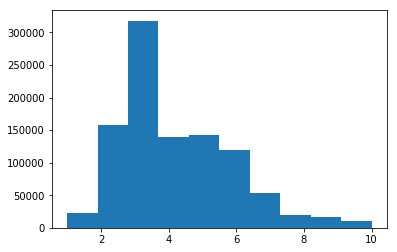

In [18]:
_=plt.hist(pred.predicted_age)